Dataset Link: https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow import keras

## **Load the data** 

In [8]:
batch_size = 16
img_height = 256
img_width = 256

In [9]:
train_dir = '/kaggle/input/vegetable-image-dataset/Vegetable Images/train'
test_dir = '/kaggle/input/vegetable-image-dataset/Vegetable Images/test'
validation_dir = '/kaggle/input/vegetable-image-dataset/Vegetable Images/validation'

In [10]:
train_ds = keras.utils.image_dataset_from_directory(
  train_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = keras.utils.image_dataset_from_directory(
  test_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size)

validation_ds = keras.utils.image_dataset_from_directory(
  validation_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.


In [14]:
class_names = train_ds.class_names


In [15]:
train_ds

<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

## **Visualise Data** 

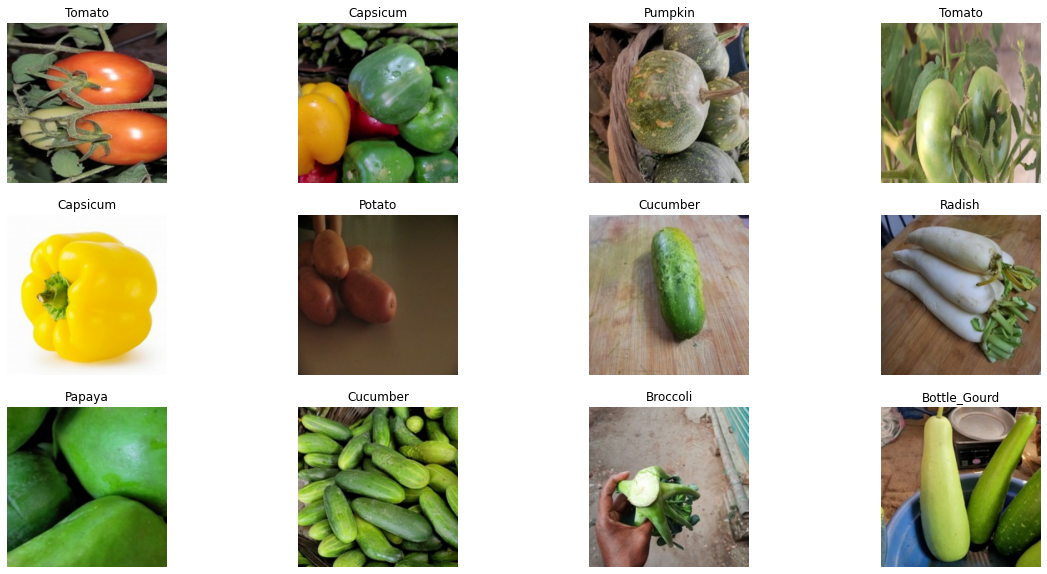

In [20]:
# To plot the first twelve images
plt.figure(figsize=(20, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## **Batch shape**

In [17]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 256, 256, 3)
(16,)


## **Train a model**

In [50]:
data_augmentation = keras.Sequential(
  [
    keras.layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
  ]
)

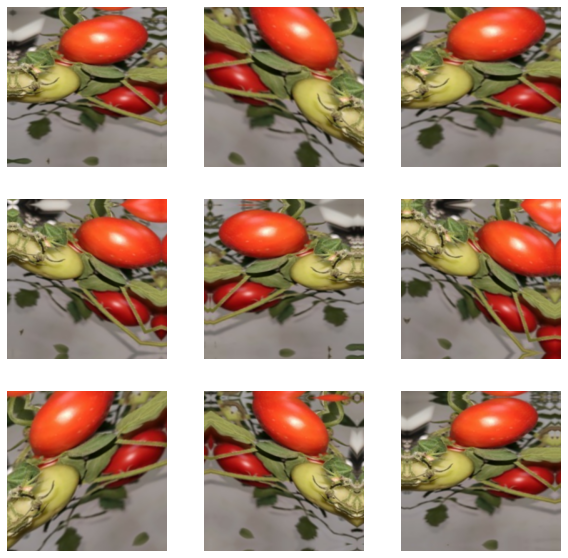

In [51]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [52]:
num_classes = 16

model = keras.Sequential([
    data_augmentation,
  keras.layers.Rescaling(1./255),
    
  keras.layers.Conv2D(32, 3, activation='relu'),
  keras.layers.MaxPooling2D(),
    
  keras.layers.Conv2D(32, 3, activation='relu'),
  keras.layers.MaxPooling2D(),
    
  keras.layers.Conv2D(32, 3, activation='relu'),
  keras.layers.MaxPooling2D(),
  
  keras.layers.Dropout(0.2),
    
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(num_classes)
])

In [53]:
model.compile(
  optimizer='nadam',
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [54]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_5 (Sequential)    (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling_5 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 125, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 60, 60, 32)       

In [55]:
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs= 5
)

Epoch 1/5
938/938 [==============================] - 51s 52ms/step - loss: 1.0584 - accuracy: 0.6506 - val_loss: 0.8668 - val_accuracy: 0.7010
Epoch 2/5
938/938 [==============================] - 48s 51ms/step - loss: 0.4189 - accuracy: 0.8639 - val_loss: 0.4262 - val_accuracy: 0.8537
Epoch 3/5
938/938 [==============================] - 50s 53ms/step - loss: 0.2838 - accuracy: 0.9130 - val_loss: 0.2615 - val_accuracy: 0.9187
Epoch 4/5
938/938 [==============================] - 48s 51ms/step - loss: 0.2049 - accuracy: 0.9360 - val_loss: 0.2463 - val_accuracy: 0.9280
Epoch 5/5
938/938 [==============================] - 49s 52ms/step - loss: 0.1787 - accuracy: 0.9447 - val_loss: 0.1737 - val_accuracy: 0.9463


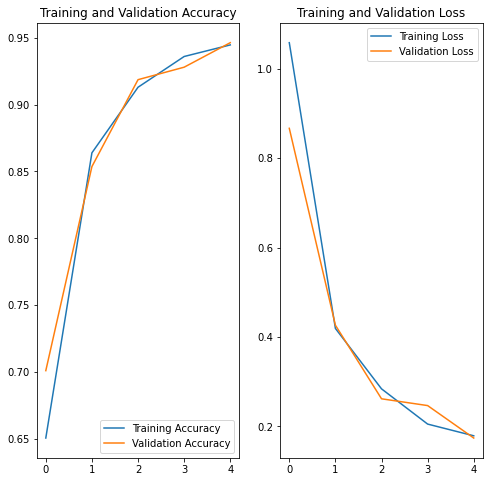

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## **Test**

In [67]:
img_path = '/kaggle/input/vegetable-image-dataset/Vegetable Images/test/Potato/1010.jpg'
img = tf.keras.utils.load_img(
    img_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Potato with a 100.00 percent confidence.


In [68]:
score, acc = model.evaluate(test_ds)
print('Test score:', score)
print('Test accuracy:', acc)

188/188 [==============================] - 22s 114ms/step - loss: 0.1709 - accuracy: 0.9447
Test score: 0.17094309628009796
Test accuracy: 0.9446666836738586
